In [3]:
import torch
import numpy as np
import os
import json
def compute_perceptual_iou(
    box_1,
    box_2,
):
    """
    Computes 'Perceptual' IoU [Kong+, BLT'22]
    """
    # box_1: [N, 4]  box_2: [N, 4]

    if isinstance(box_1, np.ndarray):
        lib = np
    #elif isinstance(box_1, FloatTensor):
    #    lib = torch
    else:
        raise NotImplementedError(type(box_1))
    box_1 = box_1.T
    box_2 = box_2.T
    l1, t1, r1, b1 = box_1[0],box_1[1],box_1[2],box_1[3]#convert_xywh_to_ltrb(box_1.T)
    l2, t2, r2, b2 = box_2[0],box_2[1],box_2[2],box_2[3]#convert_xywh_to_ltrb(box_2.T)
    a1, a2 = (r1 - l1) * (b1 - t1), (r2 - l2) * (b2 - t2)

    # intersection
    l_max = lib.maximum(l1, l2)
    r_min = lib.minimum(r1, r2)
    t_max = lib.maximum(t1, t2)
    b_min = lib.minimum(b1, b2)
    cond = (l_max < r_min) & (t_max < b_min)
    ai = lib.where(cond, (r_min - l_max) * (b_min - t_max), lib.zeros_like(a1[0]))

    # numpy-only procedure in this part
    #if isinstance(box_1, FloatTensor):
    #    unique_box_1 = np.unique(box_1.numpy(), axis=0)
    
    unique_box_1 = np.unique(box_1.T, axis=0)
    print(box_1.T)
    print(unique_box_1)
    N = 32
    l1, t1, r1, b1 = [
        (x * N).round().astype(np.int32).clip(0, N)
        for x in unique_box_1.T
    ]
    canvas = np.zeros((N, N))
    for (l, t, r, b) in zip(l1, t1, r1, b1):
        canvas[t:b, l:r] = 1
    global_area_union = canvas.sum() / (N**2)
    print(global_area_union)
    if global_area_union > 0.0:
        iou = ai / global_area_union
        return iou
    else:
        return lib.zeros((1,))

def compute_iou(box_1, box_2):
    # box_1: [N, 4]  box_2: [N, 4]

    if isinstance(box_1, np.ndarray):
        lib = np
    elif isinstance(box_1, torch.Tensor):
        lib = torch
    else:
        raise NotImplementedError(type(box_1))


    l1, t1, r1, b1 = box_1.T
    l2, t2, r2, b2 = box_2.T
    a1, a2 = (r1 - l1) * (b1 - t1), (r2 - l2) * (b2 - t2)

    # intersection
    l_max = lib.maximum(l1, l2)
    r_min = lib.minimum(r1, r2)
    t_max = lib.maximum(t1, t2)
    b_min = lib.minimum(b1, b2)
    cond = (l_max < r_min) & (t_max < b_min)
    ai = lib.where(cond, (r_min - l_max) * (b_min - t_max),
                   lib.zeros_like(a1[0]))

    au = a1 + a2 - ai
    iou = ai / au

    return iou

log_dir = "/data1/poong/tjfwownd/PosterNUWA/log_dir/RADM/result_radm_110000_sample2"
clx_path = os.path.join(log_dir,"clses.json")#"log_dir/train_stage2_with_all_dataset_non_text/generated_sample/clses.json"
clx_gt_path = os.path.join(log_dir,"clses_gt.json")#"log_dir/train_stage2_with_all_dataset_non_text/generated_sample/clses_gt.json"
box_path = os.path.join(log_dir,"box.json")#"log_dir/train_stage2_with_all_dataset_non_text/generated_sample/box.json"
box_gt_path = os.path.join(log_dir,"box_gt.json") #"log_dir/train_stage2_with_all_dataset_non_text/generated_sample/box_gt.json"


with open(box_path, "r") as f:
    boxes = json.load(f)
    
with open(box_gt_path, "r") as f:
    boxes_gt = json.load(f)
#with open(clx_path,"r") as f:
#    clses = json.load(f)
#with open(clx_gt_path,"r") as f:
#    clses_gt = json.load(f)

index = 19

bbox = np.array(boxes[index])

bbox_gt= boxes[index]

#bbox[:,::2] /=513
#bbox[:,::2] /=750
#print(bbox)

#compute_perceptual_iou(np.array(bbox), np.array(bbox))
compute_perceptual_iou(np.array(bbox), np.array(bbox)),compute_iou(np.array(bbox), np.array(bbox))


[[ 75.43478394 163.67649841 456.7272644  220.69921875]
 [133.71125793 174.01615906 399.78291321 210.32894897]
 [127.94635773  60.79972458 403.19559479 145.21491623]]
[[ 75.43478394 163.67649841 456.7272644  220.69921875]
 [127.94635773  60.79972458 403.19559479 145.21491623]
 [133.71125793 174.01615906 399.78291321 210.32894897]]
0.0


(array([0.]), array([1., 1., 1.]))

In [9]:
np.round(bbox[0]),bbox_gt[0]

(array([ 75., 164., 457., 221.]),
 [75.43478393554688, 163.67649841308594, 456.7272644042969, 220.69921875])

# data leakage 서준

In [146]:
import numpy as np
import json

def read_json(json_pth) :
    with open(json_pth, 'r') as f:
        data = json.load(f)
    return data

def compare_image(real, fake, dsize=(750, 513)) :
    rm = np.zeros(dsize)
    fm = np.zeros(dsize)

    for x, y, a, b in real :
        x = max(0, x)
        y = max(0, y)
        a = min(513, a)
        b = min(750, b)
        rm[int(y):int(b), int(x):int(a)] = 1

    for x, y, a, b in fake :
        x = max(0, x)
        y = max(0, y)
        a = min(513, a)
        b = min(750, b)
        fm[int(y):int(b), int(x):int(a)] = 1

    return ((rm * fm).sum()) / ((rm + fm - rm*fm).sum())

def get_iou(reals, fakes) :
    #reals = read_json(real_pth)
    #fakes = read_json(fake_pth)
    comp = []
    for real,fake in zip(reals,fakes):
        comp.append(compare_image(real,fake))
        
    return comp
img_paths = read_json("/data1/poong/tjfwownd/PosterNUWA/log_dir/train_stage2_with_augment_dino_codellama_text/generated_sample/12/text_order.json")

real_path_pol = "log_dir/train_stage2_with_augment_dino_codellama_text/generated_sample/12/box_gt.json"
fake_path_pol = "log_dir/train_stage2_with_augment_dino_codellama_text/generated_sample/12/box.json"
real_pol = read_json(real_path_pol)
fake_pol = read_json(fake_path_pol)
print(np.mean(get_iou(real_pol,fake_pol)))

real_path_dsgan = "log_dir/DS_GAN/CGL-Dataset/box_gt.json"
fake_path_dsgan = "log_dir/DS_GAN/CGL-Dataset/box.json"
real_dsgan = read_json(real_path_dsgan)
fake_dsgan = read_json(fake_path_dsgan)
print(np.mean(get_iou(real_dsgan,fake_dsgan)))


real_path_radm = "log_dir/RADM/result_radm_110000_sample2/box_gt.json"

fake_path_radm = "log_dir/RADM/result_radm_110000_sample2/box.json"
real_radm = read_json(real_path_radm)
real_radm.pop(431)
fake_radm = read_json(fake_path_radm)

img_paths = read_json("log_dir/train_stage2_with_augment_dino_codellama_text/generated_sample/12/text_order.json")
img_paths.pop(431)
radm_img_paths = read_json("log_dir/RADM/result_radm_110000_sample2/text_order.json")
ind = []
for path in radm_img_paths:
    ind.append(img_paths.index(path))
# reorder
f_radm = []
for radm_index in ind:
    f_radm.append(fake_radm[radm_index])

print(np.mean(get_iou(real_radm,f_radm)))

0.368843934534535
0.40343783293255975
0.1626514695934216


In [159]:
img_paths = read_json("log_dir/train_stage2_with_augment_dino_codellama_text/generated_sample/12/text_order.json")
radm_img_paths = read_json("log_dir/RADM/result_radm_110000_sample2/text_order.json")
ind = []

img_paths.pop(431)

for path in radm_img_paths:
    ind.append(img_paths.index(path))

# reorder
f_radm = []
for radm_index in ind:
    f_radm.append(radm_img_paths[radm_index])
print(f_radm)

['O1CN010F0itD29a44dIgwbG_!!3435658083-0-alimamazszw.png', 'O1CN01SpSlZX1ejS8ycZagr_!!2211801323907-0-alimamazszw.png', 'O1CN01I2TPeZ1wYbpJsz7VN_!!2210419746320-0-alimamazszw.png', 'O1CN01HGibwr1EATrAYx6B1_!!2201196960311-0-alimamazszw.png', 'O1CN01a5fYsR1oifaDB6Q6v_!!2200797195259-0-alimamazszw.png', 'O1CN01MtJ4av24Rkqk7biP2_!!2208744527388-0-alimamazszw.png', 'O1CN01FuRySk1qefNcG6S6S_!!164745521-0-alimamazszw.png', 'O1CN01WxG5Sx1DiXiA25T9M_!!1879890250-0-alimamazszw.png', 'O1CN01yuJ91r1rj4oJK1Rbf_!!2746265666-0-alimamazszw.png', 'O1CN011S9FLo21Ie7J0Rw0x_!!3120126962-0-alimamazszw.png', 'O1CN01smdxuo1wWmGWZNx6c_!!648476316-0-alimamazszw.png', 'O1CN01Jrl7tA1zIzBBLsoch_!!2207558206692-0-alimamazszw.png', 'O1CN01cTXl9h1L2saJLHTMZ_!!2486161242-0-alimamazszw.png', 'O1CN01O7I8711SV0G9EuK6i_!!4065642251-2-alimamazszw.png', 'O1CN01SHLVgm1LwkvT1gu3j_!!2209516881364-0-alimamazszw.png', 'O1CN01Eu2sok1n7k4IJIMhx_!!2920895043-0-alimamazszw.png', 'O1CN01cUil2o2IXA75iMMHE_!!1771449295-0-alimamazszw.

In [162]:
len(img_paths),len(radm_img_paths)

(3027, 3027)

In [157]:
img_paths

['O1CN01KhZNSR1cvF4VQG4sv_!!3855613662-0-alimamazszw.png',
 'O1CN01QslVUs28b9PWlxqN6_!!2225227950-0-alimamazszw.png',
 'O1CN01eveTZ42CTbMA4WBGI_!!2207992838475-0-alimamazszw.png',
 'O1CN01OmbW7K1lvXuWeZYq5_!!1657254881-0-alimamazszw.png',
 'O1CN01djnklq1vQXFGqJNMh_!!2613416167-0-alimamazszw.png',
 'O1CN01kgNqSb1IcCJTBAYmn_!!918800913-0-alimamacc.png',
 'O1CN01JUxyzb1iNFOy4RZE9_!!2200676434400-0-alimamazszw.png',
 'O1CN01paUSen1Gyym8dI4Ql_!!1799180692-0-alimamazszw.png',
 'O1CN01oE7l9W1QY5fiWn7IJ_!!3937671987-0-alimamazszw.png',
 'O1CN01JaVr6f2E4WtcstTvN_!!123638691-0-alimamazszw.png',
 'O1CN01GRVI3a1du9kTsWupK_!!2201523113795-0-alimamazszw.png',
 'O1CN01COYkI91fEb3MSmmoe_!!3161393975-2-alimamazszw.png',
 'O1CN01jt7yzX1acnvbobAdb_!!2102393351-0-alimamazszw.png',
 'O1CN01DaflSH1EGR1t1iQrV_!!2072490324-0-alimamazszw.png',
 'O1CN01HMc8fF1Gczl6QOpiT_!!2206359750644-0-alimamazszw.png',
 'O1CN01a2MQWx1yXLzJsj6bR_!!2211906406588-0-alimamazszw.png',
 'O1CN01kmJiFl25GaoI6l5ho_!!533497499-0-alima

In [143]:
img_paths[431]

'O1CN01QevZPq1WEkf7obEqX_!!4051182757-0-alimamazszw.png'

O1CN01uT7vL91r699icRw5s_!!485765581-0-alimamazszw.png
real


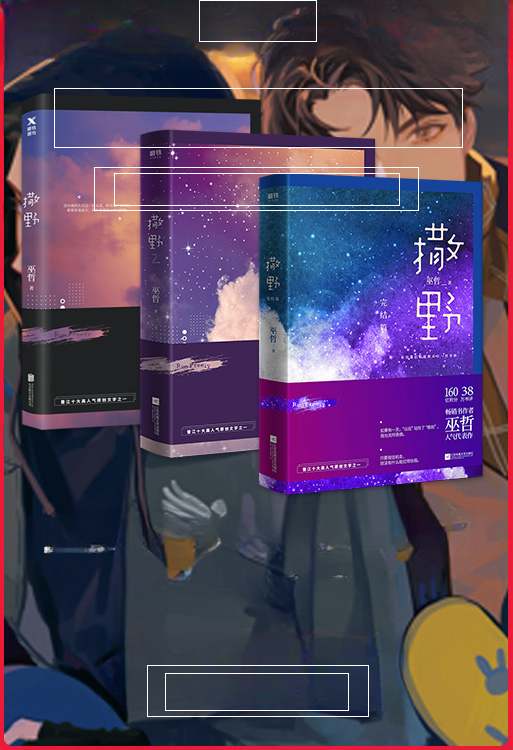

radm


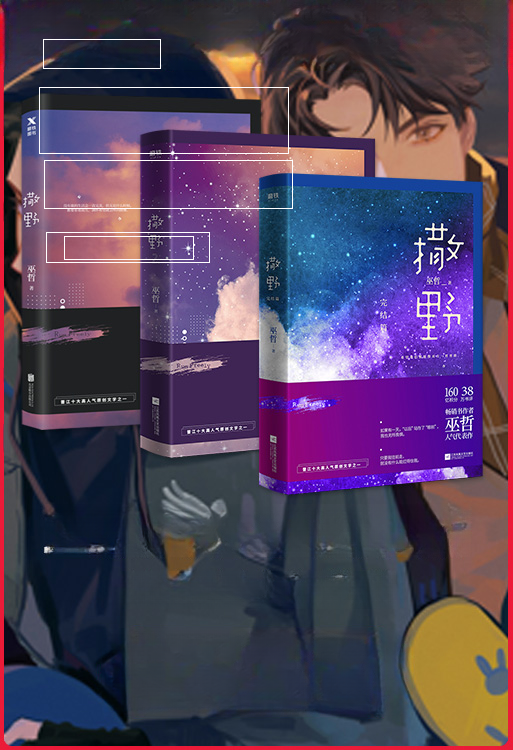

pol


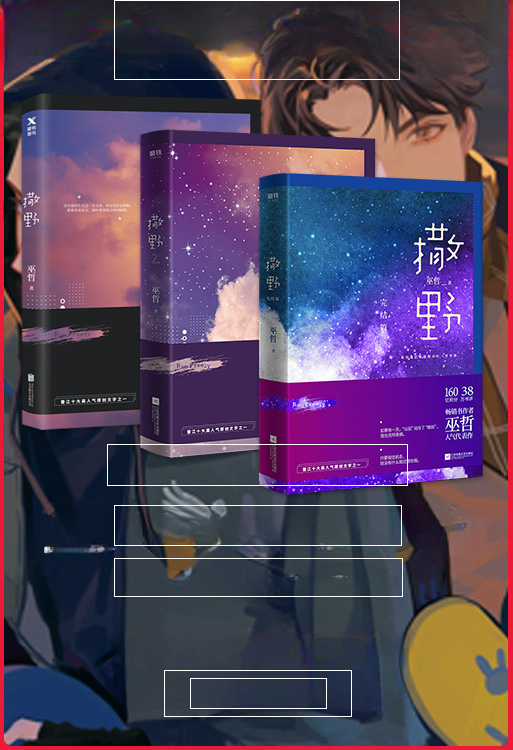

In [155]:
rm = np.zeros((750,513))
real_radm = read_json("/data1/poong/tjfwownd/PosterNUWA/log_dir/RADM/result_radm_110000_sample/box_gt.json")
fake_radm = read_json("/data1/poong/tjfwownd/PosterNUWA/log_dir/RADM/result_radm_110000_sample/box.json")
    

from PIL import Image, ImageDraw
import os
#index =670
index+=1
print(img_paths[index])
print("real")
img = Image.open(os.path.join("/data1/poong/tjfwownd/PosterNUWA/data/cgl_dataset/cgl_inpainting_all",img_paths[index]))
drawn =ImageDraw.ImageDraw(img)
for x, y, a, b in real_radm[index] :
    drawn.rectangle([x,y,a,b])
display(img)

print("radm")
img = Image.open(os.path.join("/data1/poong/tjfwownd/PosterNUWA/data/cgl_dataset/cgl_inpainting_all",img_paths[index]))
drawn =ImageDraw.ImageDraw(img)
for x, y, a, b in fake_radm[index] :
    drawn.rectangle([x,y,a,b])
display(img)

print("pol")
img = Image.open(os.path.join("/data1/poong/tjfwownd/PosterNUWA/data/cgl_dataset/cgl_inpainting_all",img_paths[index]))
drawn =ImageDraw.ImageDraw(img)

for x, y, a, b in fake_pol[index+1] :
    #a+=x
    #b+=y
    drawn.rectangle([x,y,a,b])

display(img)


In [102]:
img_paths.index("O1CN01ZFuZRz1Meixc5j77O_!!2207645211460-2-alimamazszw.png")

670